In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import graph_statistics
import utils

from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot, df_from_dataset, errorbar_plot)

# True graph

In [2]:
_A_obs = load_npz('../data/datasets/citeseer.npz')

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
assert (train_graph.toarray() == train_graph.toarray().T).all()

# Errorbar plots: NetGAN vs our method

In [3]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

In [11]:
eval_netgan = Evaluation(experiment_root='../logs/CORA-ML/baseline_NetGan/',
                         statistic_fns=statistic_fns)
eval_netgan.aggregate_statistics(num_bins=15)

In [12]:
eval_ours = Evaluation(experiment_root='../logs/CORA-ML/Ours/',
                       statistic_fns=statistic_fns)
eval_ours.aggregate_statistics(num_bins=15)

In [13]:
models_statistics_binned = {'NetGAN' : (eval_netgan.statistics_binned, 'r', eval_netgan.get_val_criterion),
                            'LRL' : (eval_ours.statistics_binned, 'b', eval_ours.get_val_criterion)}

In [4]:
# utils.save_dict(models_statistics_binned, 'models_statistics_binned.p')
models_statistics_binned = utils.load_dict('citeseer_statistics_binned.p')

In [5]:
original_statistics = compute_original_statistics(original_graph=train_graph, statistic_fns=statistic_fns)

In [6]:
translation_dict = {'Clustering Coefficient':'Clustering coeff.',
                    'Edge Distribution Entropy':'Rel. edge\n distr. entr.',
                    'Max Degree':'Max. degree',
                    'Power Law α':'Power law exp.',
                    'Claw Count':'Claw count',
                    'Gini':'Gini coeff.',
                    'Spectral Gap':'Spectral gap',
                    'Square Count':'Square count',
                    'Triangle Count':'Triangle count',
                    'Wedge Count':'Wedge count',
                    'Edge Overlap (%)':'Edge overlap (%)',
                    'ROC-AUC Score':'ROC-AUC score',
                    'Average Precision':'Average precision'}
# show_keys = ['Assortativity', 'Clustering Coefficient', 'Edge Distribution Entropy', 'Gini',
#              'Max Degree', 'Power Law α', 'Spectral Gap', 'Triangle Count', 'Wedge Count',
#              'ROC-AUC Score', 'Square Count', 'Time (s)']
show_keys = ['Max Degree', 'Assortativity', 'Power Law α',
             'Edge Distribution Entropy', 'Clustering Coefficient', 'Gini',
             'Wedge Count', 'Triangle Count', 'Square Count']

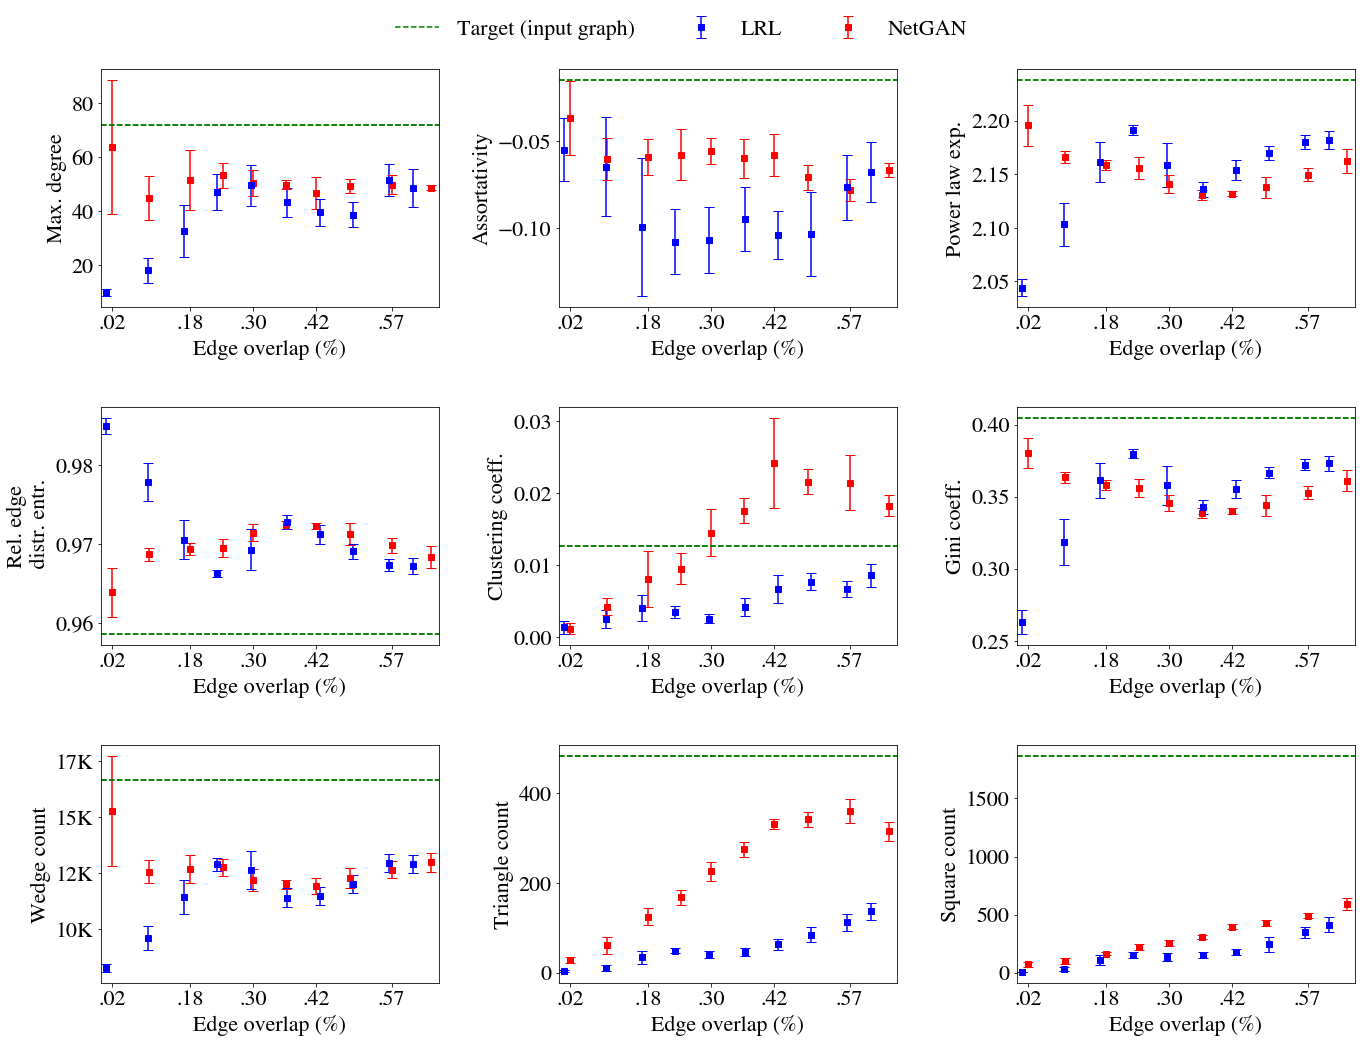

In [7]:
errorbar_plot(models_statistics_binned=models_statistics_binned,
              original_statistics=original_statistics, 
              grid_size=(3,3),
              figsize=(20, 15),
              show_keys=show_keys,
              translation_dict=translation_dict,
              max_patience=5,
              save_path='../fig/citeseer_during_training.pdf')

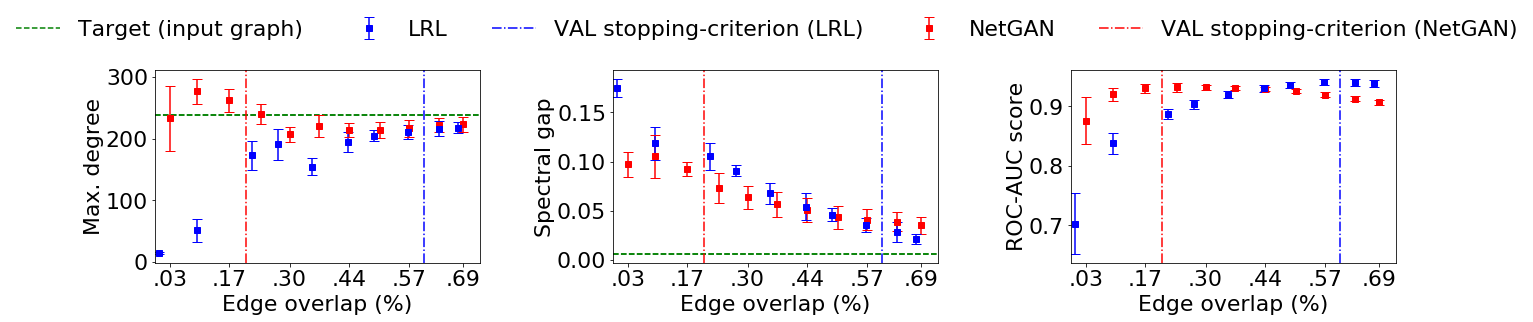

In [15]:
errorbar_plot(models_statistics_binned=models_statistics_binned,
              original_statistics=original_statistics, 
              grid_size=(1,3),
              figsize=(20, 5),
              show_keys=['Max Degree', 'Spectral Gap', 'ROC-AUC Score'],
              translation_dict=translation_dict,
              max_patience=5,
              save_path='../fig/during_training_snippet.pdf')

# Statistics

In [2]:
statistic_fns = {#'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 #'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 #'Power Law α':graph_statistics.power_law_alpha,
                 #'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 #'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

## Ours

In [3]:
eval_ours = Evaluation(experiment_root='../logs/CORA-ML/Ours/',
                       statistic_fns=statistic_fns)
eval_ours.aggregate_statistics(num_bins=10)

## Ours Test

In [6]:
eval_ours_test = Evaluation(experiment_root='../logs/CORA-ML/Ours_test_loss/',
                            statistic_fns=statistic_fns)
eval_ours_test.aggregate_statistics(num_bins=10)

## Netgan

In [8]:
eval_netgan = Evaluation(experiment_root='../logs/CORA-ML/baseline_NetGan/',
                         statistic_fns=statistic_fns)
eval_netgan.aggregate_statistics(num_bins=10)

## Forge Adjacency 

In [11]:
eval_fa = Evaluation(experiment_root='../logs/CORA-ML/baseline_FA/',
                     statistic_fns=statistic_fns)
eval_fa.aggregate_statistics(num_bins=10)

## Forge Transition

In [14]:
eval_ft = Evaluation(experiment_root='../logs/CORA-ML/baseline_FT/',
                     statistic_fns=statistic_fns)
eval_ft.aggregate_statistics(num_bins=10)

## Forge Symmetric Laplacian

In [17]:
eval_fs = Evaluation(experiment_root='../logs/CORA-ML/baseline_FS/',
                     statistic_fns=statistic_fns)
eval_fs.aggregate_statistics(num_bins=10)

## Forge Modularity Matrix

In [ ]:
eval_fm = Evaluation(experiment_root='../logs/CORA-ML/baseline_FM/',
                     statistic_fns=statistic_fns)
eval_fm.aggregate_statistics(num_bins=10)

## Configuration Model

In [23]:
eval_conf = Evaluation(experiment_root='../logs/CORA-ML/baseline_conf/',
                       statistic_fns=statistic_fns)
eval_conf.aggregate_statistics(num_bins=10)

# Summary

In [26]:
tabular = tabular_from_statistics(EO_criterion=0.5,
                                  statistics={'ours': eval_ours.mean_std,
                                              'ours_test': eval_ours_test.mean_std,
                                              'netgan': eval_netgan.mean_std,
                                              'fa': eval_fa.mean_std,
                                              'ft': eval_ft.mean_std,
                                              'fs': eval_fs.mean_std,
                                              'fm': eval_fm.mean_std,
                                              'conf': eval_conf.mean_std
                                             })

In [27]:
df = df_from_tabular(tabular)

In [28]:
df

,Claw Count,Square Count,Wedge Count,Edge Overlap (%),ROC-AUC Score,Average Precision,Time (s)
ours,1738945.600 ± 238717.883,6755.950 ± 505.775,81647.350 ± 2806.074,0.551 ± 0.008,0.925 ± 0.005,0.933 ± 0.005,14.253 ± 0.175
ours_test,1980118.400 ± 296499.610,7073.800 ± 161.327,84063.400 ± 2857.278,0.556 ± 0.003,0.924 ± 0.004,0.934 ± 0.003,14.460 ± 0.155
netgan,2173600.500 ± 341728.405,5095.154 ± 393.711,83243.949 ± 3562.418,0.555 ± 0.029,0.921 ± 0.005,0.924 ± 0.004,7117.745 ± 1225.187
fa,489182.050 ± 61525.613,1128.950 ± 78.341,48245.750 ± 930.903,0.525 ± 0.005,0.565 ± 0.000,0.660 ± 0.000,2.193 ± 0.057
ft,724098.000 ± 104610.585,1547.600 ± 82.679,57796.250 ± 1475.635,0.560 ± 0.005,0.706 ± 0.000,0.793 ± 0.000,2.031 ± 0.106
fs,1524738.500 ± 185145.351,2133.450 ± 164.138,77062.600 ± 2337.801,0.529 ± 0.005,0.788 ± 0.000,0.847 ± 0.000,2.278 ± 0.083
fm,489679.850 ± 62757.346,1112.000 ± 56.135,48225.300 ± 1168.063,0.523 ± 0.005,0.564 ± 0.000,0.659 ± 0.000,2.189 ± 0.051
conf,2693617.350 ± 89329.125,3148.600 ± 205.397,97634.150 ± 905.817,0.504 ± 0.001,NaN,NaN,0.115 ± 0.013


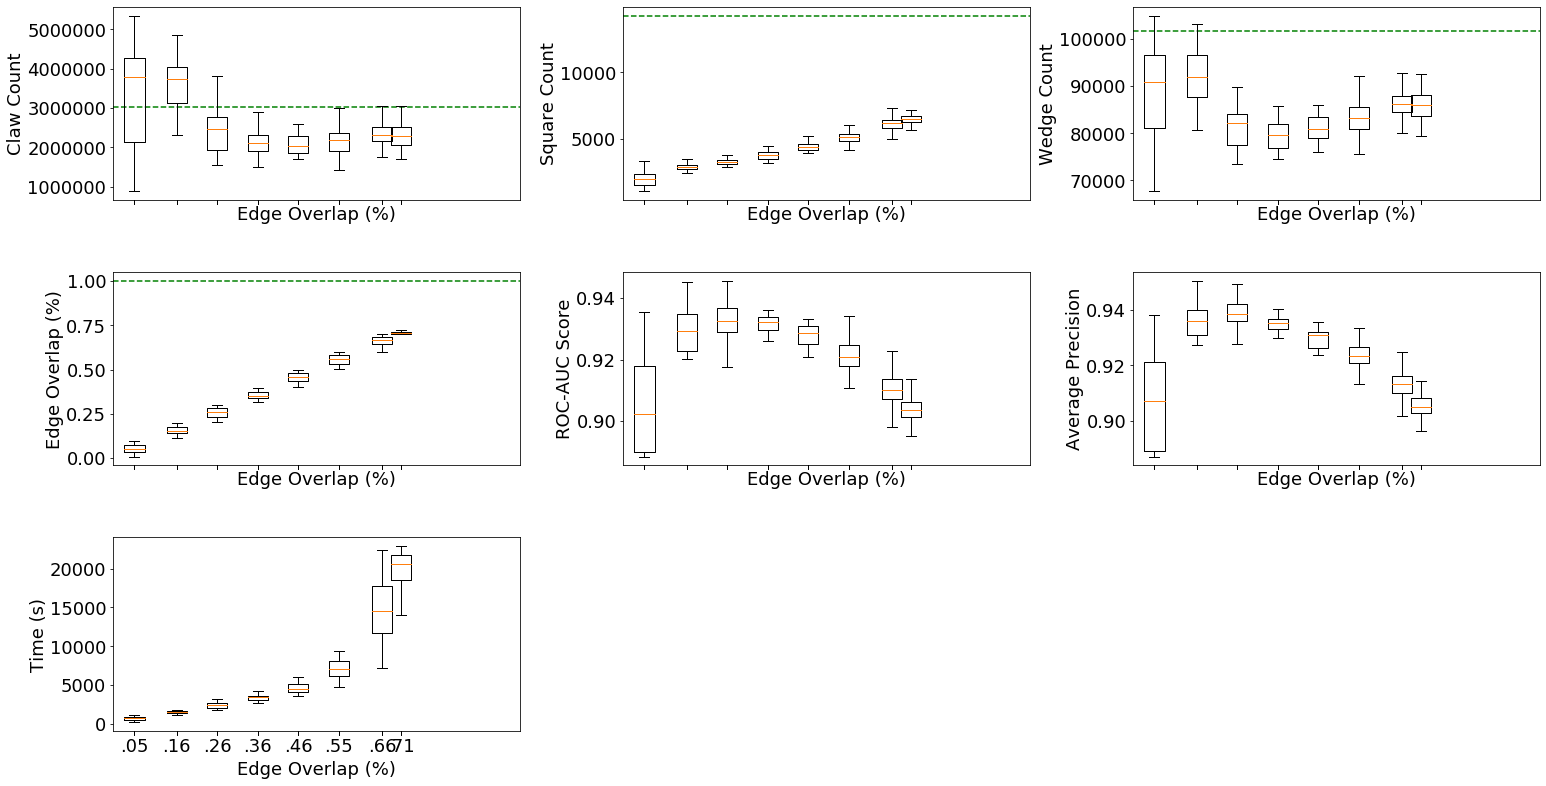

In [86]:
boxplot(statistics_binned=eval_netgan.statistics_binned, original_statistics=original_statistics, save_path='../fig/netgan.pdf')

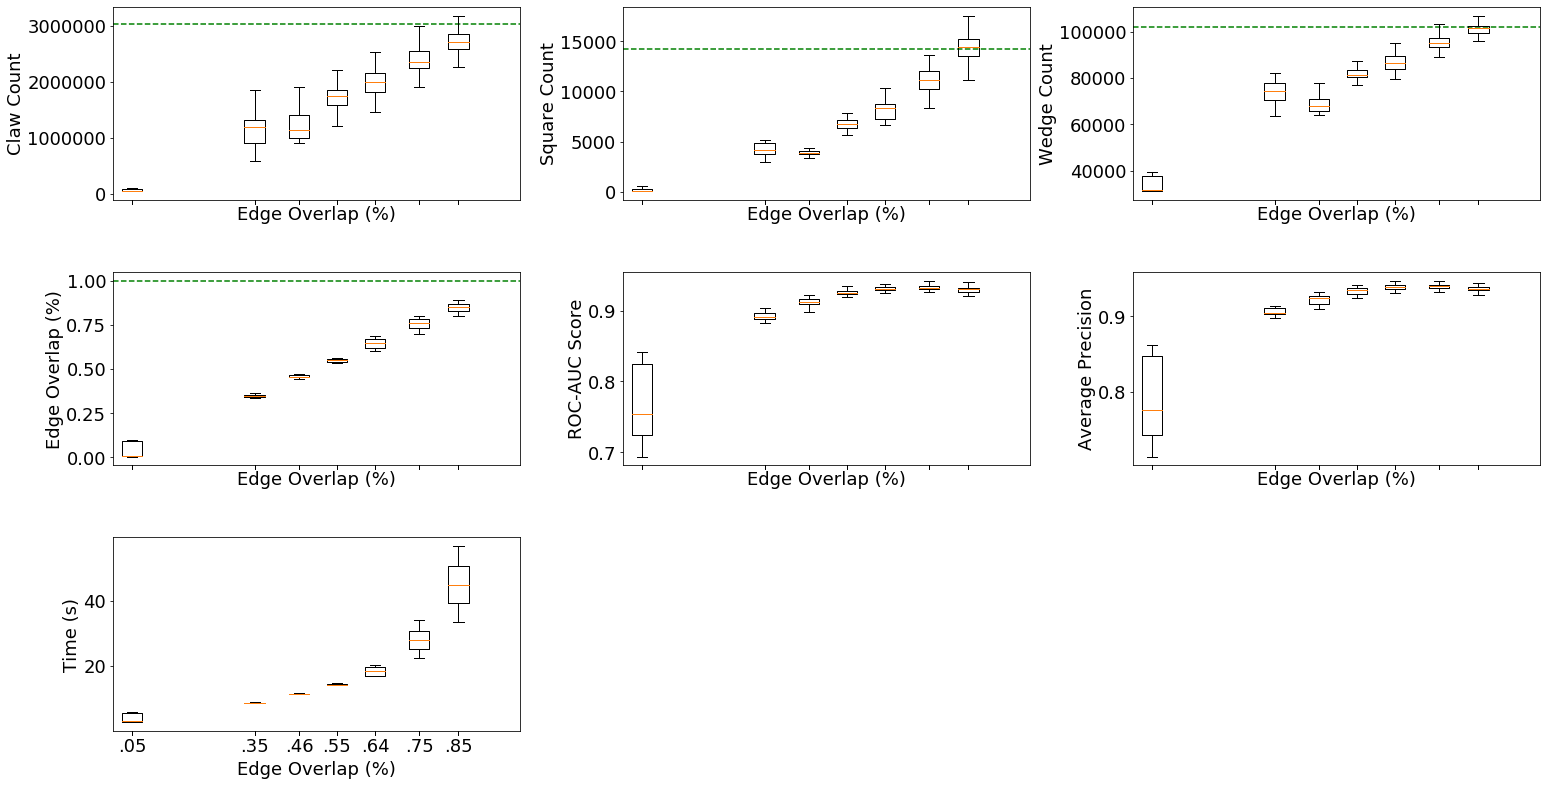

In [22]:
boxplot(statistics_binned=eval_ours.statistics_binned, original_statistics=original_statistics, save_path='../fig/ours.pdf')

# Main Table

In [14]:
_A_obs = load_npz('../data/datasets/CORA_ML.npz')

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
assert (train_graph.toarray() == train_graph.toarray().T).all()

Community densities

In [15]:
class_memberships = utils.load_dict('../data/datasets/cora_classes.p')

def get_intra_community_density(class_memberships):
    def intra_community_density(A):
        return graph_statistics.community_densities(A, class_memberships)[0]
    return intra_community_density

def get_inter_community_density(class_memberships):
    def inter_community_density(A):
        return graph_statistics.community_densities(A, class_memberships)[1]
    return inter_community_density

intra_community_density = get_intra_community_density(class_memberships)
inter_community_density = get_inter_community_density(class_memberships)

In [16]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 #'Claw Count':graph_statistics.claw_count,
                 'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
#                   'Intra com.' : intra_community_density,
#                   'Inter com.' : inter_community_density,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 'Spectral Gap':graph_statistics.spectral_gap,
#                  'Square Count':graph_statistics.square_count,
                 'Triangle Count':graph_statistics.triangle_count,
#                  'Wedge Count':graph_statistics.wedge_count,
                 }

In [17]:
df, evals = df_from_dataset(path_to_dataset='../logs/CORA-ML/',
                            statistic_fns=statistic_fns,
                            target_overlap=0.495,
                            original_graph=train_graph,
                            max_trials=5)

In [18]:
df

,Assortativity,Clustering Coefficient,Max Degree,Power Law α,Spectral Gap,Triangle Count,Edge Overlap (%),ROC-AUC Score,Average Precision,Time (s)
CORA-ML,-0.076264,0.002771,238.0,1.855065,0.006114,2802.0,1.000000,NaN,NaN,NaN
baseline_NetGan,-0.074142,0.002051,207.6,1.792136,0.046713,1290.4,0.504438,0.925992,0.927050,5351.374102
baseline_FS,-0.084049,0.001474,172.4,1.788538,0.023109,652.6,0.500870,0.787900,0.846239,38.630006
baseline_FT,-0.058367,0.002553,139.4,1.769471,0.029537,557.8,0.565119,0.709044,0.798294,33.409426
baseline_FA,-0.041861,0.002999,121.4,1.722574,0.037910,443.6,0.525490,0.560806,0.648291,32.277159
Ours_test_loss,-0.077284,0.002388,189.6,1.815219,0.049616,1284.2,0.509892,0.936694,0.942431,16.683436
Ours,-0.076249,0.002225,194.2,1.826938,0.044633,1335.6,0.545334,0.924478,0.933122,14.165029
baseline_conf,-0.052063,0.000660,225.6,1.856242,0.082635,583.4,0.503258,NaN,NaN,0.109623
baseline_FM,-0.042582,0.002966,122.4,1.720652,0.047959,436.6,0.525520,0.557462,0.647160,47.815948


In [19]:
# df_for_paper = df.drop(['Edge Overlap (%)'], axis=1)
df_for_paper = df.reindex(['CORA-ML', 'baseline_conf', 'baseline_FA', 'baseline_FT',
                                     'baseline_FS',
                                     'baseline_FM',
                                     'baseline_NetGan',
                                     'Ours_test_loss'])

In [20]:
df_for_paper[['Max Degree', 'Assortativity', 'Triangle Count', 'Power Law α', 'Clustering Coefficient',
              'Spectral Gap', 'ROC-AUC Score', 'Time (s)', 'Edge Overlap (%)']]

,Max Degree,Assortativity,Triangle Count,Power Law α,Clustering Coefficient,Spectral Gap,ROC-AUC Score,Time (s),Edge Overlap (%)
CORA-ML,238.0,-0.076264,2802.0,1.855065,0.002771,0.006114,NaN,NaN,1.000000
baseline_conf,225.6,-0.052063,583.4,1.856242,0.000660,0.082635,NaN,0.109623,0.503258
baseline_FA,121.4,-0.041861,443.6,1.722574,0.002999,0.037910,0.560806,32.277159,0.525490
baseline_FT,139.4,-0.058367,557.8,1.769471,0.002553,0.029537,0.709044,33.409426,0.565119
baseline_FS,172.4,-0.084049,652.6,1.788538,0.001474,0.023109,0.787900,38.630006,0.500870
baseline_FM,122.4,-0.042582,436.6,1.720652,0.002966,0.047959,0.557462,47.815948,0.525520
baseline_NetGan,207.6,-0.074142,1290.4,1.792136,0.002051,0.046713,0.925992,5351.374102,0.504438
Ours_test_loss,189.6,-0.077284,1284.2,1.815219,0.002388,0.049616,0.936694,16.683436,0.509892


## Ours Test

In [61]:
eval_ours_test = Evaluation(experiment_root='../logs/CORA-ML/Ours_test_loss/',
                            statistic_fns=statistic_fns)

In [62]:
graphs, stats = eval_ours_test.get_specific_overlap_graph(.43)

In [64]:
means_dict = dict.fromkeys(stats[0].keys(),0)

In [65]:
n = len(stats.keys())
for key in means_dict.keys():
    for i in range(n):
        means_dict[key] += stats[i][key] / n

In [66]:
means_dict

{'Assortativity': -0.0745716516179013,
 'Clustering Coefficient': 0.0022907853052224537,
 'Max Degree': 198.4,
 'Power Law α': 1.8159631092894226,
 'Spectral Gap': 0.04533224467232094,
 'Triangle Count': 1339.8000000000002,
 'Edge Overlap (%)': 0.5161138139466314,
 'ROC-AUC Score': 0.9377723758016594,
 'Average Precision': 0.9445588959885978,
 'Time (s)': 16.105956315994263}